In [1]:
import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step

In [2]:
# Clear any leftover state from previous colabs run.
# (This is not necessary for normal programs.)
tf.compat.v1.enable_resource_variables()
tf.compat.v1.enable_v2_behavior()
nest = tf.compat.v2.nest

The Multi-Armed Bandit problem (MAB) is a special case of Reinforcement Learning: an agent collects rewards in an environment by taking some actions after observing some state of the environment. The main difference between general RL and MAB is that in MAB, we assume that the action taken by the agent does not influence the next state of the environment. Therefore, agents do not model state transitions, credit rewards to past actions, or "plan ahead" to get to reward-rich states.

As in other RL domains, the goal of a MAB agent is to find a policy that collects as much reward as possible. It would be a mistake, however, to always try to exploit the action that promises the highest reward, because then there is a chance that we miss out on better actions if we do not explore enough. This is the main problem to be solved in (MAB), often called the exploration-exploitation dilemma.


In TF-Agents, the environment class serves the role of giving information on the current state (this is called observation or context), receiving an action as input, performing a state transition, and outputting a reward. This class also takes care of resetting when an episode ends, so that a new episode can start. This is realized by calling a reset function when a state is labelled as "last" of the episode.

In [3]:
class BanditPyEnvironment(py_environment.PyEnvironment):
    def __init__(self, observation_spec, action_spec):
        self._observation_spec = observation_spec
        self._action_spec = action_spec
        super(BanditPyEnvironment, self).__init__()
    
    # Helper functions.
    def action_spec(self):
        return self._action_spec
    
    def observation_spec(self):
        return self._observation_spec
    
    def _empty_observation(self):
        return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                     self.observation_spec())
    # These two functions below should not be overridden by subclasses.
    def _reset(self):
        return ts.restart(self._observe(), batch_size=self.batch_size)
    
    def _step(self, action):
        reward = self._apply_action(action)
        return ts.termination(self._observe(), reward)
    
    @abc.abstractmethod
    def _observe(self):
        """Returns an observation."""
    
    @abc.abstractmethod
    def _apply_action(self, action):
        """Applies `action` to the Environment and returns the corresponding reward."""

In [4]:
class SimplePyEnvironment(BanditPyEnvironment):
    def __init__(self):
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')
        super(SimplePyEnvironment, self).__init__(observation_spec, action_spec)
    
    def _observe(self):
        self._observation = np.random.randint(-2, 3, (1,))
        return self._observation
    
    def _apply_action(self, action):
        return action * self._observation

The following class gives a very simple environment for which the observation is a random integer between -2 and 2, there are 3 possible actions (0, 1, 2), and the reward is the product of the action and the observation.

In [5]:
environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 2 #@param

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

observation: -1
action: 2
reward: -2.000000


### TF Environments

One can define a bandit environment by subclassing BanditTFEnvironment, or, similarly to RL environments, one can define a BanditPyEnvironment and wrap it with TFPyEnvironment. For the sake of simplicity, we go with the latter option in this tutorial.

In [6]:
tf_environment = tf_py_environment.TFPyEnvironment(environment)

A policy in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.

As with environments, there are two ways to construct a policy: One can create a PyPolicy and wrap it with TFPyPolicy, or directly create a TFPolicy. Here we elect to go with the direct method.

Since this example is quite simple, we can define the optimal policy manually. The action only depends on the sign of the observation, 0 when is negative and 2 when is positive.

In [7]:
class SignPolicy(tf_policy.Base):
    def __init__(self):
        observation_spec = tensor_spec.BoundedTensorSpec(
            shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
        time_step_spec = ts.time_step_spec(observation_spec)

        action_spec = tensor_spec.BoundedTensorSpec(
            shape=(), dtype=tf.int32, minimum=0, maximum=2)

        super(SignPolicy, self).__init__(time_step_spec=time_step_spec,
                                         action_spec=action_spec)
    
    def _distribution(self, time_step):
        pass
    
    def _variables(self):
        return ()
    
    def _action(self, time_step, policy_state, seed):
        observation_sign = tf.cast(tf.sign(time_step.observation[0]), dtype=tf.int32)
        action = observation_sign + 1
        return policy_step.PolicyStep(action, policy_state)

Now we can request an observation from the environment, call the policy to choose an action, then the environment will output the reward:

In [8]:
sign_policy = SignPolicy()

current_time_step = tf_environment.reset()
print('Observation:')
print (current_time_step.observation)
action = sign_policy.action(current_time_step).action
print('Action:')
print (action)
reward = tf_environment.step(action).reward
print('Reward:')
print(reward)

Observation:
tf.Tensor([[2]], shape=(1, 1), dtype=int64)
Action:
tf.Tensor([2], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


The way bandit environments are implemented ensures that every time we take a step, we not only receive the reward for the action we took, but also the next observation.

In [9]:
step = tf_environment.reset()
action = 1
next_step = tf_environment.step(action)
reward = next_step.reward
next_observation = next_step.observation
print("Reward: ")
print(reward)
print("Next observation:")
print(next_observation)

Reward: 
tf.Tensor([[-1.]], shape=(1, 1), dtype=float32)
Next observation:
tf.Tensor([[-2]], shape=(1, 1), dtype=int64)


### Agents

The API for bandit agents does not differ from that of RL agents: the agent just needs to implement the _initialize and _train methods, and define a policy and a collect_policy.

In [11]:
class TwoWayPyEnvironment(BanditPyEnvironment):
    def __init__(self):
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')

        # Flipping the sign with probability 1/2.
        self._reward_sign = 2 * np.random.randint(2) - 1
        print("reward sign:")
        print(self._reward_sign)

        super(TwoWayPyEnvironment, self).__init__(observation_spec, action_spec)
    
    def _observe(self):
        self._observation = np.random.randint(-2, 3, (1,))
        return self._observation
    
    def _apply_action(self, action):
        return self._reward_sign * action * self._observation[0]

two_way_tf_environment = tf_py_environment.TFPyEnvironment(TwoWayPyEnvironment())

reward sign:
-1


### A More Complicated Policy

A more complicated environment calls for a more complicated policy. We need a policy that detects the behavior of the underlying environment. There are three situations that the policy needs to handle:

- The agent has not detected know yet which version of the environment is running.
- The agent detected that the original version of the environment is running.
- The agent detected that the flipped version of the environment is running.

We define a tf_variable named _situation to store this information encoded as values in [0, 2], then make the policy behave accordingly.

In [26]:
class TwoWaySignPolicy(tf_policy.Base):
    def __init__(self, situation):
        observation_spec = tensor_spec.BoundedTensorSpec(
            shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
        action_spec = tensor_spec.BoundedTensorSpec(
            shape=(), dtype=tf.int32, minimum=0, maximum=2)
        time_step_spec = ts.time_step_spec(observation_spec)
        self._situation = situation
        super(TwoWaySignPolicy, self).__init__(time_step_spec=time_step_spec,
                                               action_spec=action_spec)
    
    def _distribution(self, time_step):
        pass
    
    def _variables(self):
        return [self._situation]
    
    def _action(self, time_step, policy_state, seed):
        sign = tf.cast(tf.sign(time_step.observation[0, 0]), dtype=tf.int32)
        def case_unknown_fn():
            return tf.constant(1, shape=(1,))

        def case_normal_fn():
            return tf.constant(sign + 1, shape=(1,))
        def case_flipped_fn():
            return tf.constant(1 - sign, shape=(1,))

        cases = [(tf.equal(self._situation, 0), case_unknown_fn),
                 (tf.equal(self._situation, 1), case_normal_fn),
                 (tf.equal(self._situation, 2), case_flipped_fn)]
        action = tf.case(cases, exclusive=True)

        return policy_step.PolicyStep(action, policy_state)

### The Agent

Now it's time to define the agent that detects the sign of the environment and sets the policy appropriately.

In [27]:
class SignAgent(tf_agent.TFAgent):
    def __init__(self):
        self._situation = tf.compat.v2.Variable(0, dtype=tf.int32)
        policy = TwoWaySignPolicy(self._situation)
        time_step_spec = policy.time_step_spec
        action_spec = policy.action_spec
        super(SignAgent, self).__init__(time_step_spec=time_step_spec,
                                        action_spec=action_spec,
                                        policy=policy,
                                        collect_policy=policy,
                                        train_sequence_length=None)
    def _initialize(self):
        return tf.compat.v1.variables_initializer(self.variables)
    
    def _train(self, experience, weights=None):
        observation = experience.observation
        action = experience.action
        reward = experience.reward

        # We only need to change the value of the situation variable if it is
        # unknown (0) right now, and we can infer the situation only if the
        # observation is not 0.
        needs_action = tf.logical_and(tf.equal(self._situation, 0), tf.not_equal(reward, 0))
        
        def new_situation_fn():
            """This returns either 1 or 2, depending on the signs."""
            return (3 - tf.sign(tf.cast(observation[0, 0, 0], dtype=tf.int32) *
                          tf.cast(action[0, 0], dtype=tf.int32) *
                          tf.cast(reward[0, 0], dtype=tf.int32))) / 2
    
        new_situation = tf.cond(needs_action, new_situation_fn, lambda: self._situation)
        tf.compat.v1.assign(self._situation, new_situation)

        return tf_agent.LossInfo((), ())

In [30]:
sign_agent = SignAgent()

In the above code, the agent defines the policy, and the variable situation is shared by the agent and the policy.

Also, the parameter experience of the _train function is a trajectory:

In TF-Agents, trajectories are named tuples that contain samples from previous steps taken. These samples are then used by the agent to train and update the policy. In RL, trajectories must contain information about the current state, the next state, and whether the current episode has ended. Since in the Bandit world we do not need these things, we set up a helper function to create a trajectory:

In [28]:
# We need to add another dimension here because the agent expects the
# trajectory of shape [batch_size, time, ...], but in this tutorial we assume
# that both batch size and time are 1. Hence all the expand_dims.

def trajectory_for_bandit(initial_step, action_step, final_step):
    return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                               action=tf.expand_dims(action_step.action, 0),
                               policy_info=action_step.info,
                               reward=tf.expand_dims(final_step.reward, 0),
                               discount=tf.expand_dims(final_step.discount, 0),
                               step_type=tf.expand_dims(initial_step.step_type, 0),
                               next_step_type=tf.expand_dims(final_step.step_type, 0))

### Training an Agent

In [35]:
step = two_way_tf_environment.reset()
for _ in range(10):
    action_step = sign_agent.collect_policy.action(step)
    next_step = two_way_tf_environment.step(action_step.action)
    experience = trajectory_for_bandit(step, action_step, next_step)
    print(experience)
#     sign_agent.train(experience)
#     step = next_step

Trajectory(step_type=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>, observation=<tf.Tensor: shape=(1, 1, 1), dtype=int64, numpy=array([[[0]]])>, action=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>, policy_info=(), next_step_type=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>, reward=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, discount=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>)
Trajectory(step_type=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>, observation=<tf.Tensor: shape=(1, 1, 1), dtype=int64, numpy=array([[[0]]])>, action=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>, policy_info=(), next_step_type=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]], dtype=int32)>, reward=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.]], dtype=float32)>, discount=<tf.Tensor: shape=(1, 1

## A Real Contextual Bandit Example

In [36]:
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt

In [37]:
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param

In [48]:
def context_sampling_fn(batch_size):
    def _context_sampling_fn():
        return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
    return _context_sampling_fn

In [41]:
class LinearNormalReward(object):
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
    def __call__(self, x):
        mu = np.dot(x, self.theta)
        return np.random.normal(mu, self.sigma)

In [42]:
arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

In [43]:
environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))

In [44]:
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)

Bandits' most important metric is regret, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The RegretMetric thus needs a baseline_reward_fn function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [45]:
def compute_optimal_reward(observation):
    expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
    optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
    return optimal_action_reward

In [46]:
regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a driver, and train the agent on the data.

Note that there are two parameters that together specify the number of steps taken. num_iterations specifies how many times we run the trainer loop, while the driver will take steps_per_loop steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while some are done by the driver in every step. For example, the agent's train function is only called once per iteration. The trade-off here is that if we train more often then our policy is "fresher", on the other hand, training in bigger batches might be more time efficient.

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Text(0.5, 0, 'Number of Iterations')

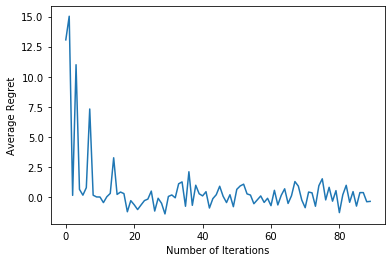

In [47]:
num_iterations = 90 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')